In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/urbansound8k/UrbanSound8K.csv
/kaggle/input/urbansound8k/fold7/164797-2-0-8.wav
/kaggle/input/urbansound8k/fold7/177537-7-2-0.wav
/kaggle/input/urbansound8k/fold7/177729-0-0-68.wav
/kaggle/input/urbansound8k/fold7/6902-2-0-18.wav
/kaggle/input/urbansound8k/fold7/518-4-0-2.wav
/kaggle/input/urbansound8k/fold7/146845-0-0-2.wav
/kaggle/input/urbansound8k/fold7/116485-3-2-4.wav
/kaggle/input/urbansound8k/fold7/518-4-0-3.wav
/kaggle/input/urbansound8k/fold7/44737-5-0-2.wav
/kaggle/input/urbansound8k/fold7/201988-5-0-3.wav
/kaggle/input/urbansound8k/fold7/181102-9-0-50.wav
/kaggle/input/urbansound8k/fold7/99812-1-6-0.wav
/kaggle/input/urbansound8k/fold7/39857-5-0-0.wav
/kaggle/input/urbansound8k/fold7/61503-2-0-6.wav
/kaggle/input/urbansound8k/fold7/162728-1-0-0.wav
/kaggle/input/urbansound8k/fold7/89443-9-0-48.wav
/kaggle/input/urbansound8k/fold7/168846-5-1-13.wav
/kaggle/input/urbansound8k/fold7/149193-5-0-2.wav
/kaggle/input/urbansound8k/fold7/71529-4-0-2.wav
/kaggle/input/u

In [22]:
AUDIO_DIR = '/kaggle/input/urbansound8k/'
ANNOTATIONS_FILE = '/kaggle/input/urbansound8k/UrbanSound8K.csv'

In [24]:
import os
import torch
import torchaudio
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from sklearn.metrics import accuracy_score
from tqdm import tqdm

SAMPLE_RATE = 16000
NUM_CLASSES = 10
BATCH_SIZE = 8
NUM_EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset Class
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, extractor, target_sample_rate, max_audio_length):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.extractor = extractor
        self.target_sample_rate = target_sample_rate
        self.max_audio_length = max_audio_length  # seconds

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_path = self._get_audio_path(idx)
        label = self._get_label(idx)
        waveform, sr = torchaudio.load(audio_path)

        # Resample
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        # Mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Trim/pad
        expected_len = self.target_sample_rate * self.max_audio_length
        if waveform.shape[1] > expected_len:
            waveform = waveform[:, :expected_len]
        elif waveform.shape[1] < expected_len:
            pad_amt = expected_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amt))

        waveform = waveform.squeeze(0)

        inputs = self.extractor(waveform, sampling_rate=self.target_sample_rate, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

    def _get_audio_path(self, idx):
        fold = f"fold{self.annotations.iloc[idx]['fold']}"
        file_name = self.annotations.iloc[idx]['slice_file_name']
        return os.path.join(self.audio_dir, fold, file_name)

    def _get_label(self, idx):
        return self.annotations.iloc[idx]['classID']

# Load AST model
extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model.to(DEVICE)

# Prepare dataset
dataset = UrbanSoundDataset(
    annotations_file=ANNOTATIONS_FILE,
    audio_dir=AUDIO_DIR,
    extractor=extractor,
    target_sample_rate=SAMPLE_RATE,
    max_audio_length=4  # 4 seconds
)

# Split train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# 🧠 Train + Test after each epoch
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    train_preds = []
    train_labels = []
    
    # Training
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = batch
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = labels.to(DEVICE)

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # Evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs, labels = batch
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            outputs = model(**inputs)
            preds = outputs.logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")


Testing: 100%|██████████| 219/219 [02:15<00:00,  1.61it/s]


Epoch 1: Loss = 0.3542, Train Acc = 89.82%, Test Acc = 95.88%


Training Epoch 2:  33%|███▎      | 287/874 [06:55<14:09,  1.45s/it]


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torchaudio
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from sklearn.metrics import accuracy_score
from tqdm import tqdm

SAMPLE_RATE = 16000
NUM_CLASSES = 10
BATCH_SIZE = 8
NUM_EPOCHS = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset Class
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, extractor, target_sample_rate, max_audio_length):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.extractor = extractor
        self.target_sample_rate = target_sample_rate
        self.max_audio_length = max_audio_length  # seconds

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_path = self._get_audio_path(idx)
        label = self._get_label(idx)
        waveform, sr = torchaudio.load(audio_path)

        # Resample
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        # Mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Trim/pad
        expected_len = self.target_sample_rate * self.max_audio_length
        if waveform.shape[1] > expected_len:
            waveform = waveform[:, :expected_len]
        elif waveform.shape[1] < expected_len:
            pad_amt = expected_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amt))

        waveform = waveform.squeeze(0)

        inputs = self.extractor(waveform, sampling_rate=self.target_sample_rate, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

    def _get_audio_path(self, idx):
        fold = f"fold{self.annotations.iloc[idx]['fold']}"
        file_name = self.annotations.iloc[idx]['slice_file_name']
        return os.path.join(self.audio_dir, fold, file_name)

    def _get_label(self, idx):
        return self.annotations.iloc[idx]['classID']

# Load AST model
extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model.to(DEVICE)

# Prepare dataset
dataset = UrbanSoundDataset(
    annotations_file=ANNOTATIONS_FILE,
    audio_dir=AUDIO_DIR,
    extractor=extractor,
    target_sample_rate=SAMPLE_RATE,
    max_audio_length=4  # 4 seconds
)

# Split train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# 🧠 Train + Test after each epoch
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    train_preds = []
    train_labels = []
    
    # Training
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = batch
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = labels.to(DEVICE)

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # Evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs, labels = batch
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            outputs = model(**inputs)
            preds = outputs.logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s]


Epoch 1: Loss = 0.3453, Train Acc = 90.42%, Test Acc = 94.50%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 2: Loss = 0.0719, Train Acc = 97.82%, Test Acc = 96.51%


Testing: 100%|██████████| 219/219 [01:48<00:00,  2.03it/s]


Epoch 3: Loss = 0.0559, Train Acc = 98.17%, Test Acc = 96.28%


Testing: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s]


Epoch 4: Loss = 0.0661, Train Acc = 97.90%, Test Acc = 98.17%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s]


Epoch 5: Loss = 0.0365, Train Acc = 98.90%, Test Acc = 96.39%


Testing: 100%|██████████| 219/219 [01:46<00:00,  2.05it/s]


Epoch 6: Loss = 0.0220, Train Acc = 99.27%, Test Acc = 94.79%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 7: Loss = 0.0581, Train Acc = 98.24%, Test Acc = 97.65%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s]


Epoch 8: Loss = 0.0257, Train Acc = 99.30%, Test Acc = 96.62%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 9: Loss = 0.0257, Train Acc = 99.20%, Test Acc = 97.14%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 10: Loss = 0.0259, Train Acc = 99.18%, Test Acc = 97.25%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s]


Epoch 11: Loss = 0.0353, Train Acc = 98.95%, Test Acc = 97.77%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.05it/s]


Epoch 12: Loss = 0.0057, Train Acc = 99.83%, Test Acc = 97.60%


Testing: 100%|██████████| 219/219 [01:46<00:00,  2.05it/s]


Epoch 13: Loss = 0.0036, Train Acc = 99.91%, Test Acc = 97.25%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s]


Epoch 14: Loss = 0.0416, Train Acc = 98.91%, Test Acc = 95.65%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 15: Loss = 0.0278, Train Acc = 99.14%, Test Acc = 96.85%


Testing: 100%|██████████| 219/219 [01:49<00:00,  2.00it/s]


Epoch 16: Loss = 0.0035, Train Acc = 99.89%, Test Acc = 97.77%


Testing: 100%|██████████| 219/219 [01:50<00:00,  1.99it/s]


Epoch 17: Loss = 0.0378, Train Acc = 98.81%, Test Acc = 96.45%


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.05it/s]


Epoch 18: Loss = 0.0075, Train Acc = 99.79%, Test Acc = 96.05%


Training Epoch 19:  82%|████████▏ | 714/874 [17:13<03:50,  1.44s/it]

In [36]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    train_preds = []
    train_labels = []
    
    # Training
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = batch
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = labels.to(DEVICE)

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # Evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs, labels = batch
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            outputs = model(**inputs)
            preds = outputs.logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")


Testing: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s]


Epoch 1: Loss = 0.0035, Train Acc = 99.90%, Test Acc = 98.11%


Training Epoch 2:   1%|          | 10/874 [00:15<22:49,  1.59s/it]


KeyboardInterrupt: 

In [21]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [28]:
trainer.save_model("/kaggle/outputs/my_model/")


Epoch 2: Loss = 0.0000, Train Acc = 99.90%, Test Acc = 98.11%


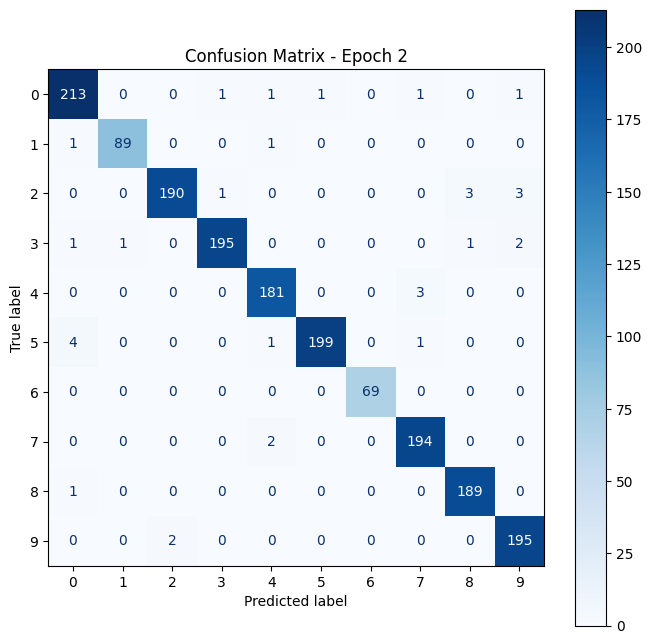

In [37]:
# 1. Import these at the top of your file
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2. After evaluation (after you have test_preds and test_labels)

# Calculate Accuracy
test_acc = accuracy_score(test_labels, test_preds)

print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

# --- Confusion Matrix Code ---
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # you can adjust the size
disp.plot(cmap='Blues', ax=ax, values_format='d')  # 'd' for integer formatting

plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.grid(False)  # Optional: Removes background grid for cleaner look
plt.show()


Epoch 3: Loss = 0.0004, Train Acc = 99.50%, Test Acc = 97.82%


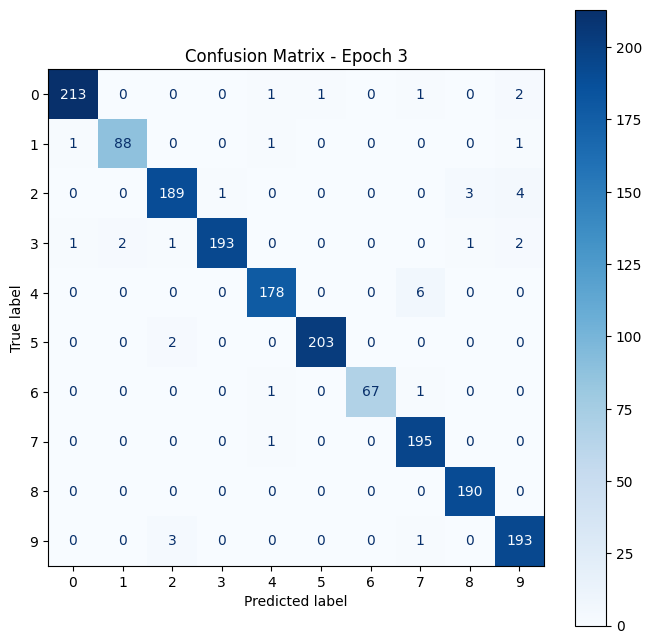

In [35]:
# 1. Import these at the top of your file
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2. After evaluation (after you have test_preds and test_labels)

# Calculate Accuracy
test_acc = accuracy_score(test_labels, test_preds)

print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

# --- Confusion Matrix Code ---
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # you can adjust the size
disp.plot(cmap='Blues', ax=ax, values_format='d')  # 'd' for integer formatting

plt.title(f"Confusion Matrix - Epoch {epoch+1}")
plt.grid(False)  # Optional: Removes background grid for cleaner look
plt.show()
